# Python ML Project

# Import libraries 

In [676]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import csv
from datetime import datetime as dt
from sklearn.model_selection import (train_test_split,cross_val_score,RepeatedStratifiedKFold,RandomizedSearchCV,KFold)
from sklearn.preprocessing import (LabelEncoder,
    RobustScaler,
    OneHotEncoder,
    PolynomialFeatures)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
#from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import (
    #plot_roc_curve:RocCurveDisplay.from_predictions,RocCurveDisplay.from_estimator
    roc_auc_score,
    classification_report,
    confusion_matrix,
    #fbeta_score,f1_score,recall_score,
    roc_curve
)

# EDA

## Importing data and preprocessing

In [677]:
ddir = '../Data/books.csv'
#ddir = '..\\Data\\books.csv'

#Rows with number of elements not consistent with the number of columns in the header
with open(ddir, encoding="utf8") as fd:
    reader=csv.reader(fd)
    lines = list(reader)
    nbColumns = len(lines[0])
    print("There are {} column names in the header.".format(nbColumns))
    RowsToPrep=[[idx, row] for idx, row in enumerate(lines) if len(row) != nbColumns]
fd.close()

print("There are {} rows with number of elements not consistent with the number of columns in the header of the file.\n".format(len(RowsToPrep)))
for row in RowsToPrep:
    print(row)
#We can see that number of columns inconsistency is due to additionnal comma with the author name(s).
#Let's merge those columns then to not loose data from the dataset

There are 12 column names in the header.
There are 4 rows with number of elements not consistent with the number of columns in the header of the file.

[3349, ['12224', 'Streetcar Suburbs: The Process of Growth in Boston  1870-1900', 'Sam Bass Warner', ' Jr./Sam B. Warner', '3.58', '0674842111', '9780674842113', 'en-US', '236', '61', '6', '4/20/2004', 'Harvard University Press']]
[4703, ['16914', "The Tolkien Fan's Medieval Reader", 'David E. Smith (Turgon of TheOneRing.net', ' one of the founding members of this Tolkien website)/Verlyn Flieger/Turgon (=David E. Smith)', '3.58', '1593600119', '9781593600112', 'eng', '400', '26', '4', '4/6/2004', 'Cold Spring Press']]
[5878, ['22128', 'Patriots (The Coming Collapse)', 'James Wesley', ' Rawles', '3.63', '156384155X', '9781563841552', 'eng', '342', '38', '4', '1/15/1999', 'Huntington House Publishers']]
[8980, ['34889', "Brown's Star Atlas: Showing All The Bright Stars With Full Instructions How To Find And Use Them For Navigational Purpo

In [678]:
#Build the corrected file by duplicating each line without the two problematic column values. Then insert those column values after merging them.
prepDdir = '../Data/books_prep.csv'
#prepDdir = '..\Data\books_prep.csv'

for elt in RowsToPrep:
    prepRows = [a for idx,a in enumerate(elt[1]) if idx not in [2,3]]
    prepRows.insert(2, elt[1][2] + " -" + elt[1][3])
    elt[1] = prepRows
    print("Line {} before preprocessing\n {}".format(elt[0], lines[elt[0]]))
    lines[elt[0]] = prepRows
    print("Line {} after preprocessing\n {}\n".format(elt[0], lines[elt[0]]))

with open(prepDdir, 'w', newline='', encoding="utf8") as file:
    writer = csv.writer(file)
    writer.writerows(lines)
file.close()

Line 3349 before preprocessing
 ['12224', 'Streetcar Suburbs: The Process of Growth in Boston  1870-1900', 'Sam Bass Warner', ' Jr./Sam B. Warner', '3.58', '0674842111', '9780674842113', 'en-US', '236', '61', '6', '4/20/2004', 'Harvard University Press']
Line 3349 after preprocessing
 ['12224', 'Streetcar Suburbs: The Process of Growth in Boston  1870-1900', 'Sam Bass Warner - Jr./Sam B. Warner', '3.58', '0674842111', '9780674842113', 'en-US', '236', '61', '6', '4/20/2004', 'Harvard University Press']

Line 4703 before preprocessing
 ['16914', "The Tolkien Fan's Medieval Reader", 'David E. Smith (Turgon of TheOneRing.net', ' one of the founding members of this Tolkien website)/Verlyn Flieger/Turgon (=David E. Smith)', '3.58', '1593600119', '9781593600112', 'eng', '400', '26', '4', '4/6/2004', 'Cold Spring Press']
Line 4703 after preprocessing
 ['16914', "The Tolkien Fan's Medieval Reader", 'David E. Smith (Turgon of TheOneRing.net - one of the founding members of this Tolkien website)/

In [679]:
df = pd.read_csv(prepDdir,sep=",",index_col="bookID")

##### Check data structure

In [680]:
df.dtypes

title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
  num_pages             int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

In [681]:
#Remove the extra space in column '  num_pages'
df = df.rename(columns={'  num_pages': 'num_pages'})

In [682]:
df.dtypes

title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
num_pages               int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

##### Checking missing values

In [683]:
df.isna().sum()

title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

##### Look at first and last records

In [684]:
df.head()

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [685]:
df.tail()

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press
45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books
45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books
45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco
45641,Las aventuras de Tom Sawyer,Mark Twain,3.91,8497646983,9788497646987,spa,272,113,12,5/28/2006,Edimat Libros


In [686]:
##### Possible questions

##### Regression problem : What is the expected rating of a book according to information provided in other columns.
##### Classification problem : What is the expected "rating class" (High or Low/Medium) of a book according to information provided in other columns.

##### Transform date column

In [687]:
#Checking dates before transforming them to be reading as it should
tempDf = df.copy()
publication_date = pd.to_datetime(tempDf['publication_date'],format='%m/%d/%Y', errors='coerce')
print("*** Number of invalid parsing set to NaT: {}.\n".format(publication_date.isna().sum()))

*** Number of invalid parsing set to NaT: 2.



In [688]:
#There are some invalid dates. Let's display the corresponding lines.
tempIndex = list(tempDf.loc[publication_date.isna(),:].index)
print("*** Index of invalid publication dates : {}\n".format(tempIndex))
print("*** Invalid publication dates : {}\n".format(tempDf.loc[publication_date.isna(),['publication_date']]))
print("*** Records with invalid parsing set to NaT in tempDf for publication date : : {}\n".format(df.loc[tempIndex]))

*** Index of invalid publication dates : [31373, 45531]

*** Invalid publication dates :        publication_date
bookID                 
31373        11/31/2000
45531         6/31/1982

*** Records with invalid parsing set to NaT in tempDf for publication date : :                                                     title  \
bookID                                                      
31373   In Pursuit of the Proper Sinner (Inspector Lyn...   
45531          Montaillou  village occitan de 1294 à 1324   

                                                authors  average_rating  \
bookID                                                                    
31373                                 Elizabeth  George            4.10   
45531   Emmanuel Le Roy Ladurie/Emmanuel Le Roy-Ladurie            3.96   

              isbn         isbn13 language_code  num_pages  ratings_count  \
bookID                                                                      
31373   0553575104  9780553575101  

In [689]:
#We have only two lines with inconsistence day for the displayed month. Therefore we update the date by the ones retreived on Internet.
#https://www.goodreads.com/book/show/31373.In_Pursuit_of_the_Proper_Sinner?ref=nav_sb_ss_1_13
#https://www.chasse-aux-livres.fr/prix/0553575104/in-pursuit-of-the-proper-sinner-elizabeth-george
#31/10/2000
#"https://www.goodreads.com/book/show/45531
#30/06/1982

#This change will not impact the following results as we are going to focus only on the publication year.

df['publication_date'].replace('11/31/2000', '10/31/2000', inplace=True)
df['publication_date'].replace('6/31/1982', '6/30/1982', inplace=True)

In [690]:
#Check that everything is ok with the dates now.
tempDf = df.copy()
publication_date = pd.to_datetime(tempDf['publication_date'],format='%m/%d/%Y', errors='coerce')
print("*** Number of invalid parsing set to NaT: {}.\n".format(publication_date.isna().sum()))

*** Number of invalid parsing set to NaT: 0.



In [691]:
#As everything is ok now, transform date in the oroginal dataframe column to be reading as it should
df['publication_date']=pd.to_datetime(df['publication_date'],format='%m/%d/%Y')

#create a new variable with the publication date to analize it later
df['publicationYear'] = pd.DatetimeIndex(df['publication_date']).year

In [692]:
#Check of the types after transformation
df.dtypes

title                         object
authors                       object
average_rating               float64
isbn                          object
isbn13                         int64
language_code                 object
num_pages                      int64
ratings_count                  int64
text_reviews_count             int64
publication_date      datetime64[ns]
publisher                     object
publicationYear                int32
dtype: object

##### Transform langage code column

In [693]:
#checking how many different languages and if it's possible regrouping
df[['language_code','title']].groupby('language_code').count()

,title
language_code,
ale,1
ara,1
en-CA,7
en-GB,214
en-US,1409
eng,8911
enm,3
fre,144
ger,99


In [694]:
#regrouping cathegories
def map_leng_categories(category):
    if category in ["en-CA","en-GB","en-US",'eng']:
        return 'eng'
    elif category in ['fre', 'spa', 'ger', 'jpn']:
        return category
    else:
        return 'other'

# Apply the function, create new column
df['language_code_grouped'] = df['language_code'].apply(map_leng_categories)

df[['language_code_grouped','title']].groupby('language_code_grouped').count()


,title
language_code_grouped,
eng,10541
fre,144
ger,99
jpn,46
other,79
spa,218


##### Transform average rate column to categories (for the classification problem) 

In [695]:
def f(row):
    if row['average_rating'] >= 4.25:
        val = 'HigRat'
    else:
        val = 'LMRat'
    return val

df['catRating'] = df.apply(f, axis=1)

df[['catRating','title']].groupby('catRating').count()

,title
catRating,
HigRat,1502
LMRat,9625


## Analyzing data

In [696]:
df.select_dtypes(["float64","int64","int32"]).describe()

,average_rating,isbn13,num_pages,ratings_count,text_reviews_count,publicationYear
count,11127.000000,1.112700e+04,11127.000000,1.112700e+04,11127.000000,11127.000000
mean,3.933631,9.759888e+12,336.376921,1.793641e+04,541.854498,2000.167520
std,0.352445,4.428964e+11,241.127305,1.124794e+05,2576.176608,8.248836
min,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000,1900.000000
25%,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000,1998.000000
50%,3.960000,9.780586e+12,299.000000,7.450000e+02,46.000000,2003.000000
75%,4.135000,9.780873e+12,416.000000,4.993500e+03,237.500000,2005.000000
max,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000,2020.000000


array([[<Axes: title={'center': 'average_rating'}>,
        <Axes: title={'center': 'isbn13'}>],
       [<Axes: title={'center': 'num_pages'}>,
        <Axes: title={'center': 'ratings_count'}>],
       [<Axes: title={'center': 'text_reviews_count'}>,
        <Axes: title={'center': 'publicationYear'}>]], dtype=object)

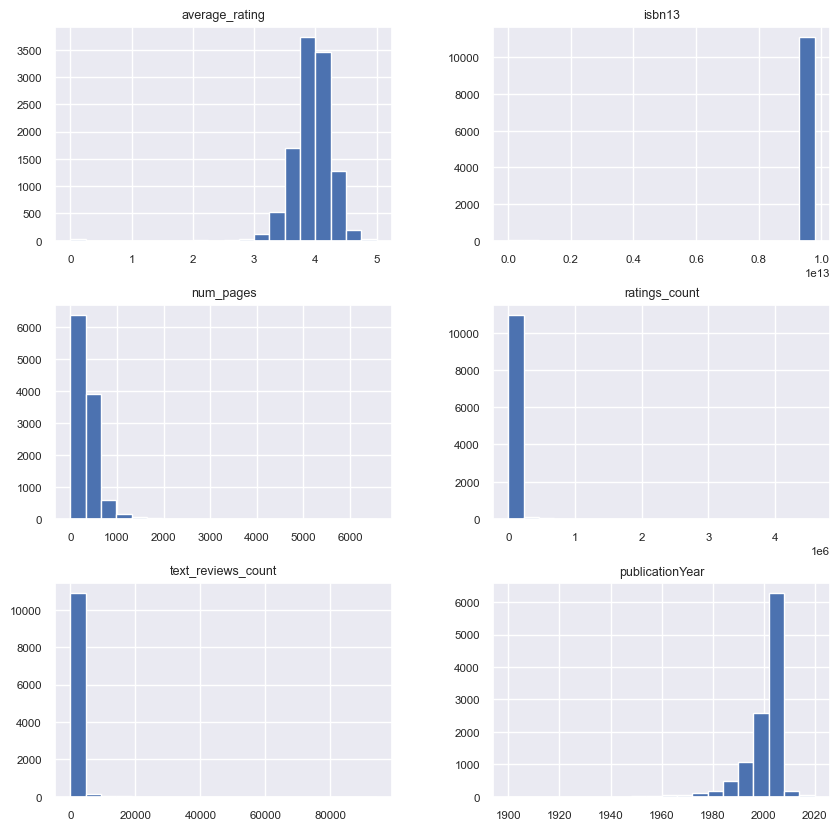

In [697]:
df.select_dtypes(["float64","int64","int32"]).hist(figsize=(10, 10), bins=20)

# Feature Engineering

## Correlation matrix

<Axes: >

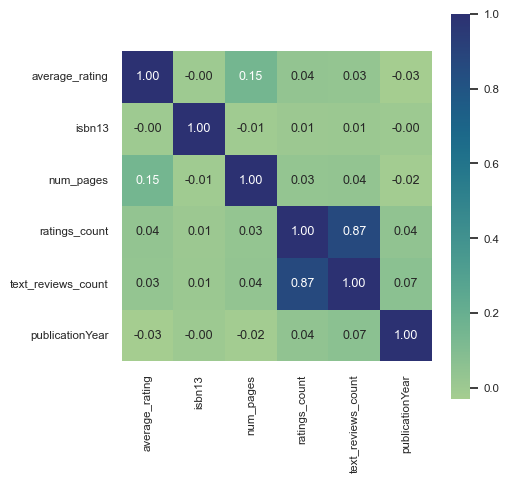

In [698]:
mcorrel = df.select_dtypes(["float64","int64","int32"]).corr(method="pearson")

fig, ax = plt.subplots(figsize=(5, 5))
sns.set(font_scale=0.75)
sns.heatmap(
    mcorrel,
    square=True,
    ax=ax,
    cmap="crest",
    annot=True, fmt=".2f"
)
#ax.set_yticklabels(ax.get_yticklabels(),size=10)
#plt.savefig(os.path.join(Folders.reports, "G_Mcorrel.png"))
#plt.clf()

In [699]:
#High correlation between ratings_count and text_reviews_count which makes sense as we can expect that when a text has been reviewed, a rate has most probably be provided as well.
#This also mean that we can keep only one of these two columns for modeling.

#Many correlations are very low. Therefore, we could expect poor results from linear models (regression problem).

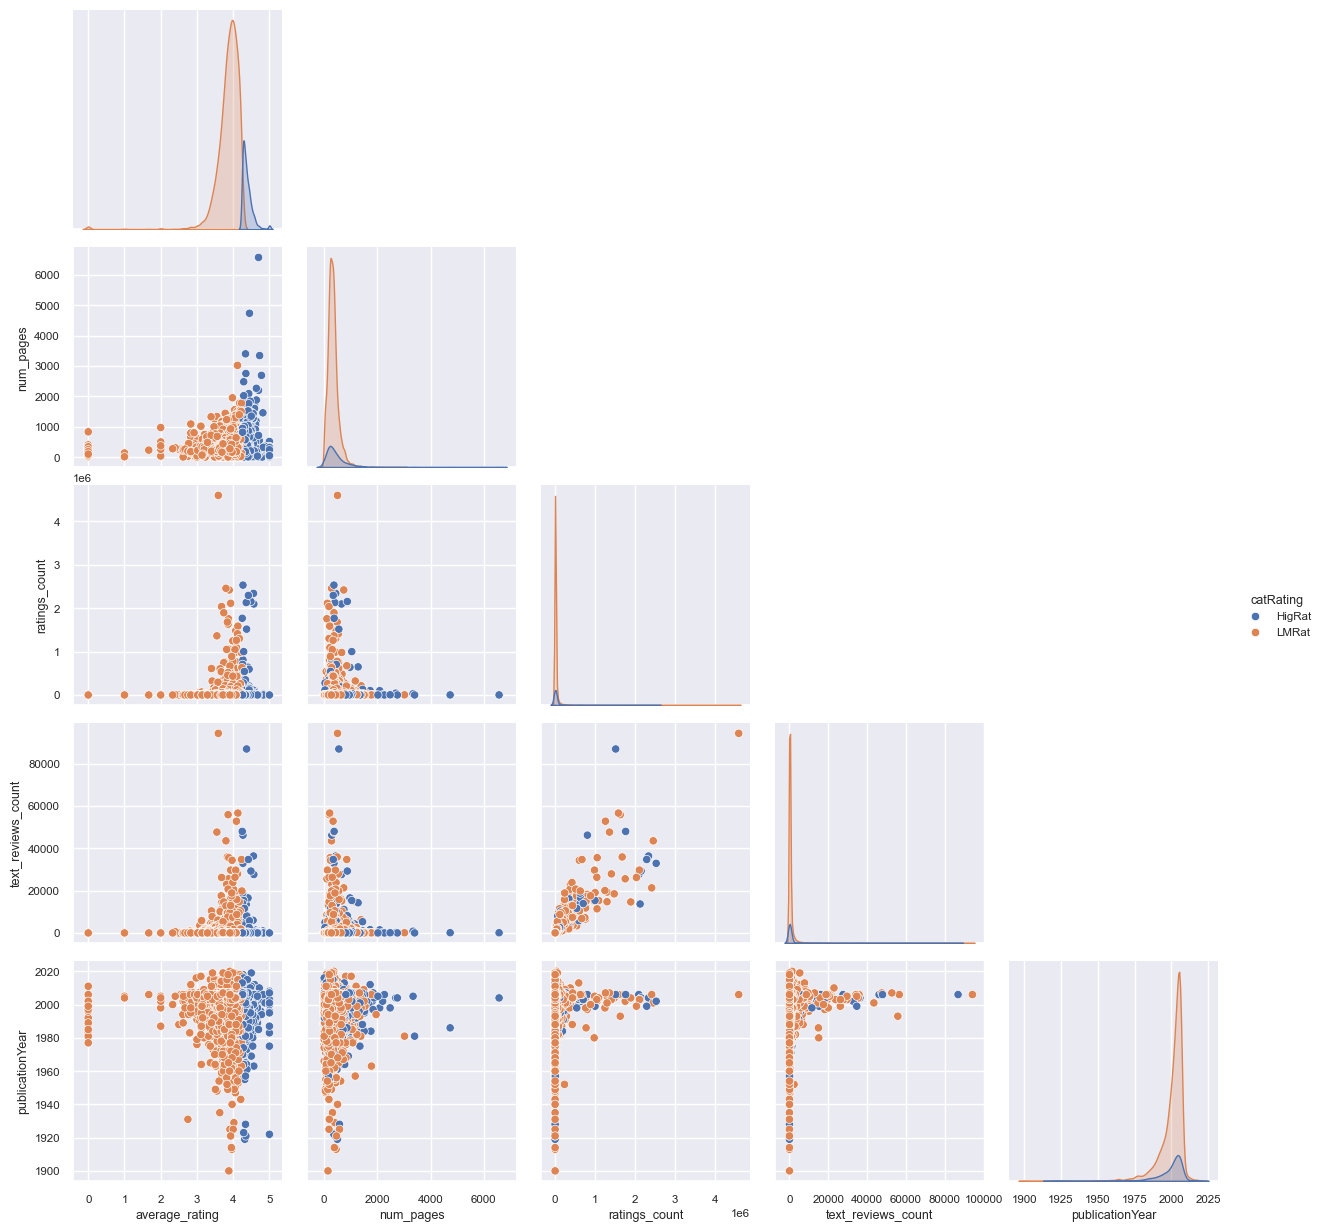

In [700]:
col = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
        'publicationYear',"catRating"]

sns.pairplot(df[col],hue="catRating", corner=True) 

In [701]:
#We can see one more time that a linear approach makes more sense mainly between ratings_count and text_reviews_count.

<Axes: xlabel='average_rating', ylabel='Count'>

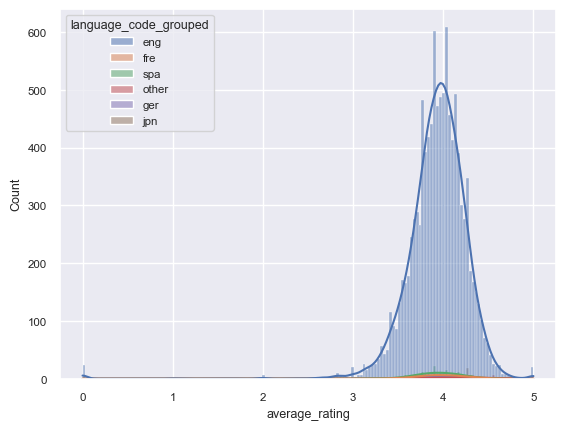

In [702]:
sns.histplot(data=df, x="average_rating", kde=True,hue='language_code_grouped')

In [703]:
fig = px.box(df, x="language_code_grouped", y="average_rating", points="all")
fig.show()

## Authors column

In [704]:
#Number of unique authors
print(len(df['authors'].unique()))

#Authors sorted by the number of books written
tempDf = df[['authors','title']].groupby(['authors'])['authors'] \
    .count() \
        .reset_index(name='count') \
            .sort_values(['count'], ascending=False) \
            #.head(100)
tempDf

6643


,authors,count
4750,P.G. Wodehouse,40
5790,Stephen King,40
5473,Rumiko Takahashi,39
4714,Orson Scott Card,35
46,Agatha Christie,33
...,...,...
812,Carolyn Keene/Mildred Benson,1
3066,Joanna Weaver,1
3065,Joanna Strange,1
3064,Joan Sinclair/James Farrer,1


In [705]:
#Most (at least 75%) of authors have actually written only 1 book
print(tempDf.describe())

             count
count  6643.000000
mean      1.674996
std       2.280117
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max      40.000000


<Axes: >

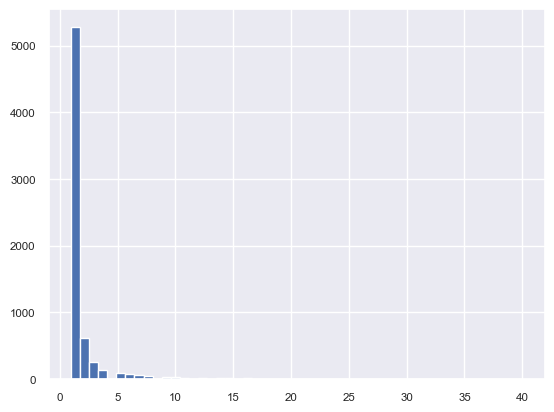

In [706]:
#Histogramme for number of authors depending on number of publications
tempDf['count'].hist(bins=50)

array([[<Axes: title={'center': 'count'}>]], dtype=object)

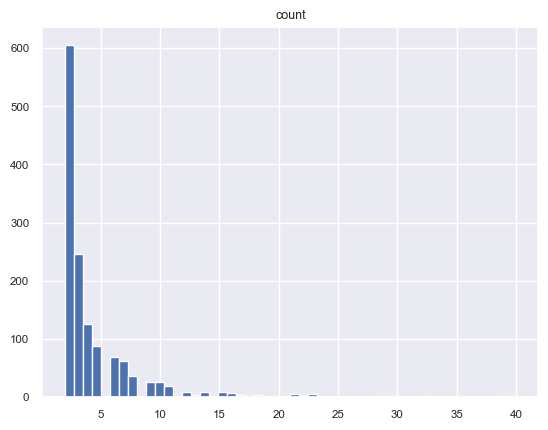

In [707]:
#Histogramme for number of authors depending on number of publications, when they have written more than 1 book
tempDf[tempDf['count'] > 1].hist(bins=50)

       mean_average_rating
count          5282.000000
mean              3.924335
std               0.403375
min               0.000000
25%               3.770000
50%               3.960000
75%               4.140000
max               5.000000
[[<Axes: title={'center': 'mean_average_rating'}>]]


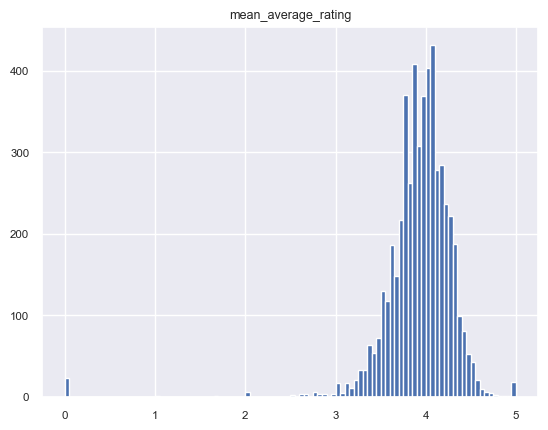

In [708]:
#When we look at how ratings are distributed amoung authors having only one book
#we can see that the ratings are more or less symetrically distributed around the mean (close to the median).

temp = df.copy()
temp2 = temp[['authors','average_rating']].groupby('authors') \
    .agg({'authors':'size', 'average_rating':'mean'}) \
    .rename(columns={'authors':'count','average_rating':'mean_average_rating'}) \

temp2 = temp2[temp2['count']==1][["mean_average_rating"]]
print(temp2.describe())
print(temp2.hist(bins=100))



<Axes: xlabel='count', ylabel='mean_average_rating'>

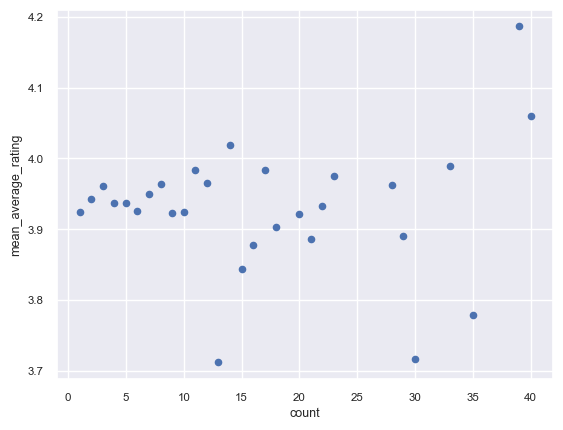

In [709]:

#We could think about creating a new column with the mean or median as an average rate
#However by looking at other number of publications by author, an obvious relation does not seem to be present.
#At least, there is not obvious linear relation
#For exemple, authors having more books in the dataset have not necessary a higher average rating.
temp = df.copy()
temp2 = temp[['authors','average_rating']].groupby('authors') \
    .agg({'authors':'size', 'average_rating':'mean'}) \
    .rename(columns={'authors':'count','average_rating':'mean_average_rating'}) \

temp2 = temp2.groupby('count') \
    .agg({'mean_average_rating':'mean'})
temp2.reset_index().plot(kind='scatter', x='count', y='mean_average_rating')

<bound method NDFrame.head of                                count  mean_average_rating
publisher                                                
10/18                              2             3.650000
1st Book Library                   1             3.580000
1st World Library                  1             4.180000
A & C Black (Childrens books)      1             4.400000
A Harvest Book/Harcourt  Inc.      1             4.070000
...                              ...                  ...
聯經出版事業股份有限公司                       2             4.400000
英文漢聲出版股份有限公司                       1             4.220000
角川書店 (Kadokawa Shoten)             2             3.815000
講談社                                6             4.283333
集英社                               12             4.237500

[2292 rows x 2 columns]>


<Axes: xlabel='count', ylabel='mean_average_rating'>

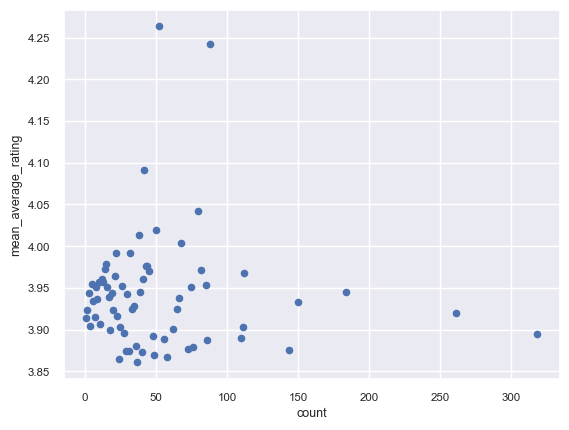

In [710]:
#It seems to be similar for the publishers
temp2 = temp[['publisher','average_rating']].groupby('publisher') \
    .agg({'publisher':'size', 'average_rating':'mean'}) \
    .rename(columns={'publisher':'count','average_rating':'mean_average_rating'}) \

print(temp2.head)

temp2 = temp2.groupby('count') \
    .agg({'mean_average_rating':'mean'})
result = pd.concat([df, temp2], axis=1, join="inner")

temp2.reset_index().plot(kind='scatter', x='count', y='mean_average_rating')

In [711]:
#how could we still add information embedded in the authors dimension ?
#There are thousands of unique authors. Therefore, hot encoding of all authors would not be relevant.
#Therefore, we can try do add take into account information related to the author by using indirect related KPIs
#For example author_ratings_count or author_number_books

#create the KPIs columns
authorsEmbededInfo = df[['authors','average_rating','ratings_count']].groupby('authors').agg({'authors':'size', 'average_rating':'mean','ratings_count':'sum'}).rename(columns={'authors':'author_number_books','average_rating':'author_books_avg_rating','ratings_count':'author_ratings_count'})
authorsEmbededInfo = authorsEmbededInfo.reset_index()

print(authorsEmbededInfo.describe())
authorsEmbededInfo

       author_number_books  author_books_avg_rating  author_ratings_count
count          6643.000000              6643.000000          6.643000e+03
mean              1.674996                 3.928449          3.004342e+04
std               2.280117                 0.381025          2.043289e+05
min               1.000000                 0.000000          0.000000e+00
25%               1.000000                 3.780000          8.200000e+01
50%               1.000000                 3.960000          5.650000e+02
75%               1.000000                 4.130000          4.787500e+03
max              40.000000                 5.000000          8.923980e+06


,authors,author_number_books,author_books_avg_rating,author_ratings_count
0,A.B. Yehoshua/Hillel Halkin,2,3.600,1308
1,A.D.P. Briggs/Leo Tolstoy/Fyodor Dostoyevsky,1,3.760,17
2,A.E. Cunningham/Harlan Ellison/Charles F. Mill...,1,4.150,13
3,A.J. Jacobs,1,3.760,24243
4,A.M. Homes,1,3.280,3282
...,...,...,...,...
6638,Émile Zola/Henri Mitterand,1,4.060,6293
6639,Émile Zola/Robert Lethbridge/Elinor Dorday,1,4.010,821
6640,Émile Zola/Robin Buss/Brian Nelson,1,3.990,5525
6641,Émile Zola/Roger Pearson,2,4.045,25111


In [712]:
#Add the new created columns into the dataset, in order to take into account information embeded in 'authors'
df = pd.merge(df, authorsEmbededInfo, on='authors')

<Axes: >

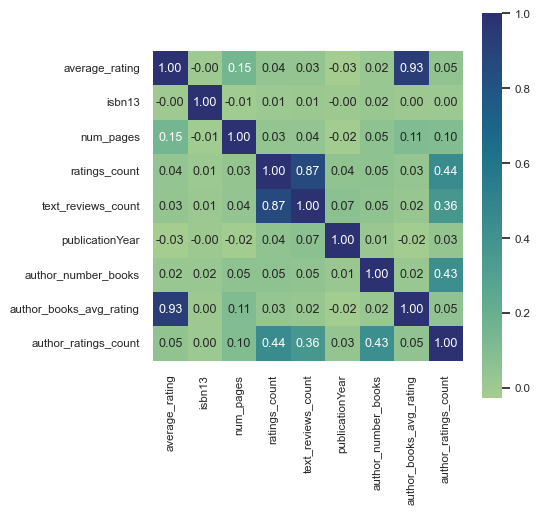

In [713]:
#Let's see the new correlation matrix
#High correlation between author_books_avg_rating and average_rating because it has been constructed on it for analysis purpose. It will not be used for modeling.
mcorrel = df.select_dtypes(["float64","int64","int32"]).corr(method="pearson")

fig, ax = plt.subplots(figsize=(5, 5))
sns.set(font_scale=0.75)
sns.heatmap(
    mcorrel,
    square=True,
    ax=ax,
    cmap="crest",
    annot=True, fmt=".2f"
)

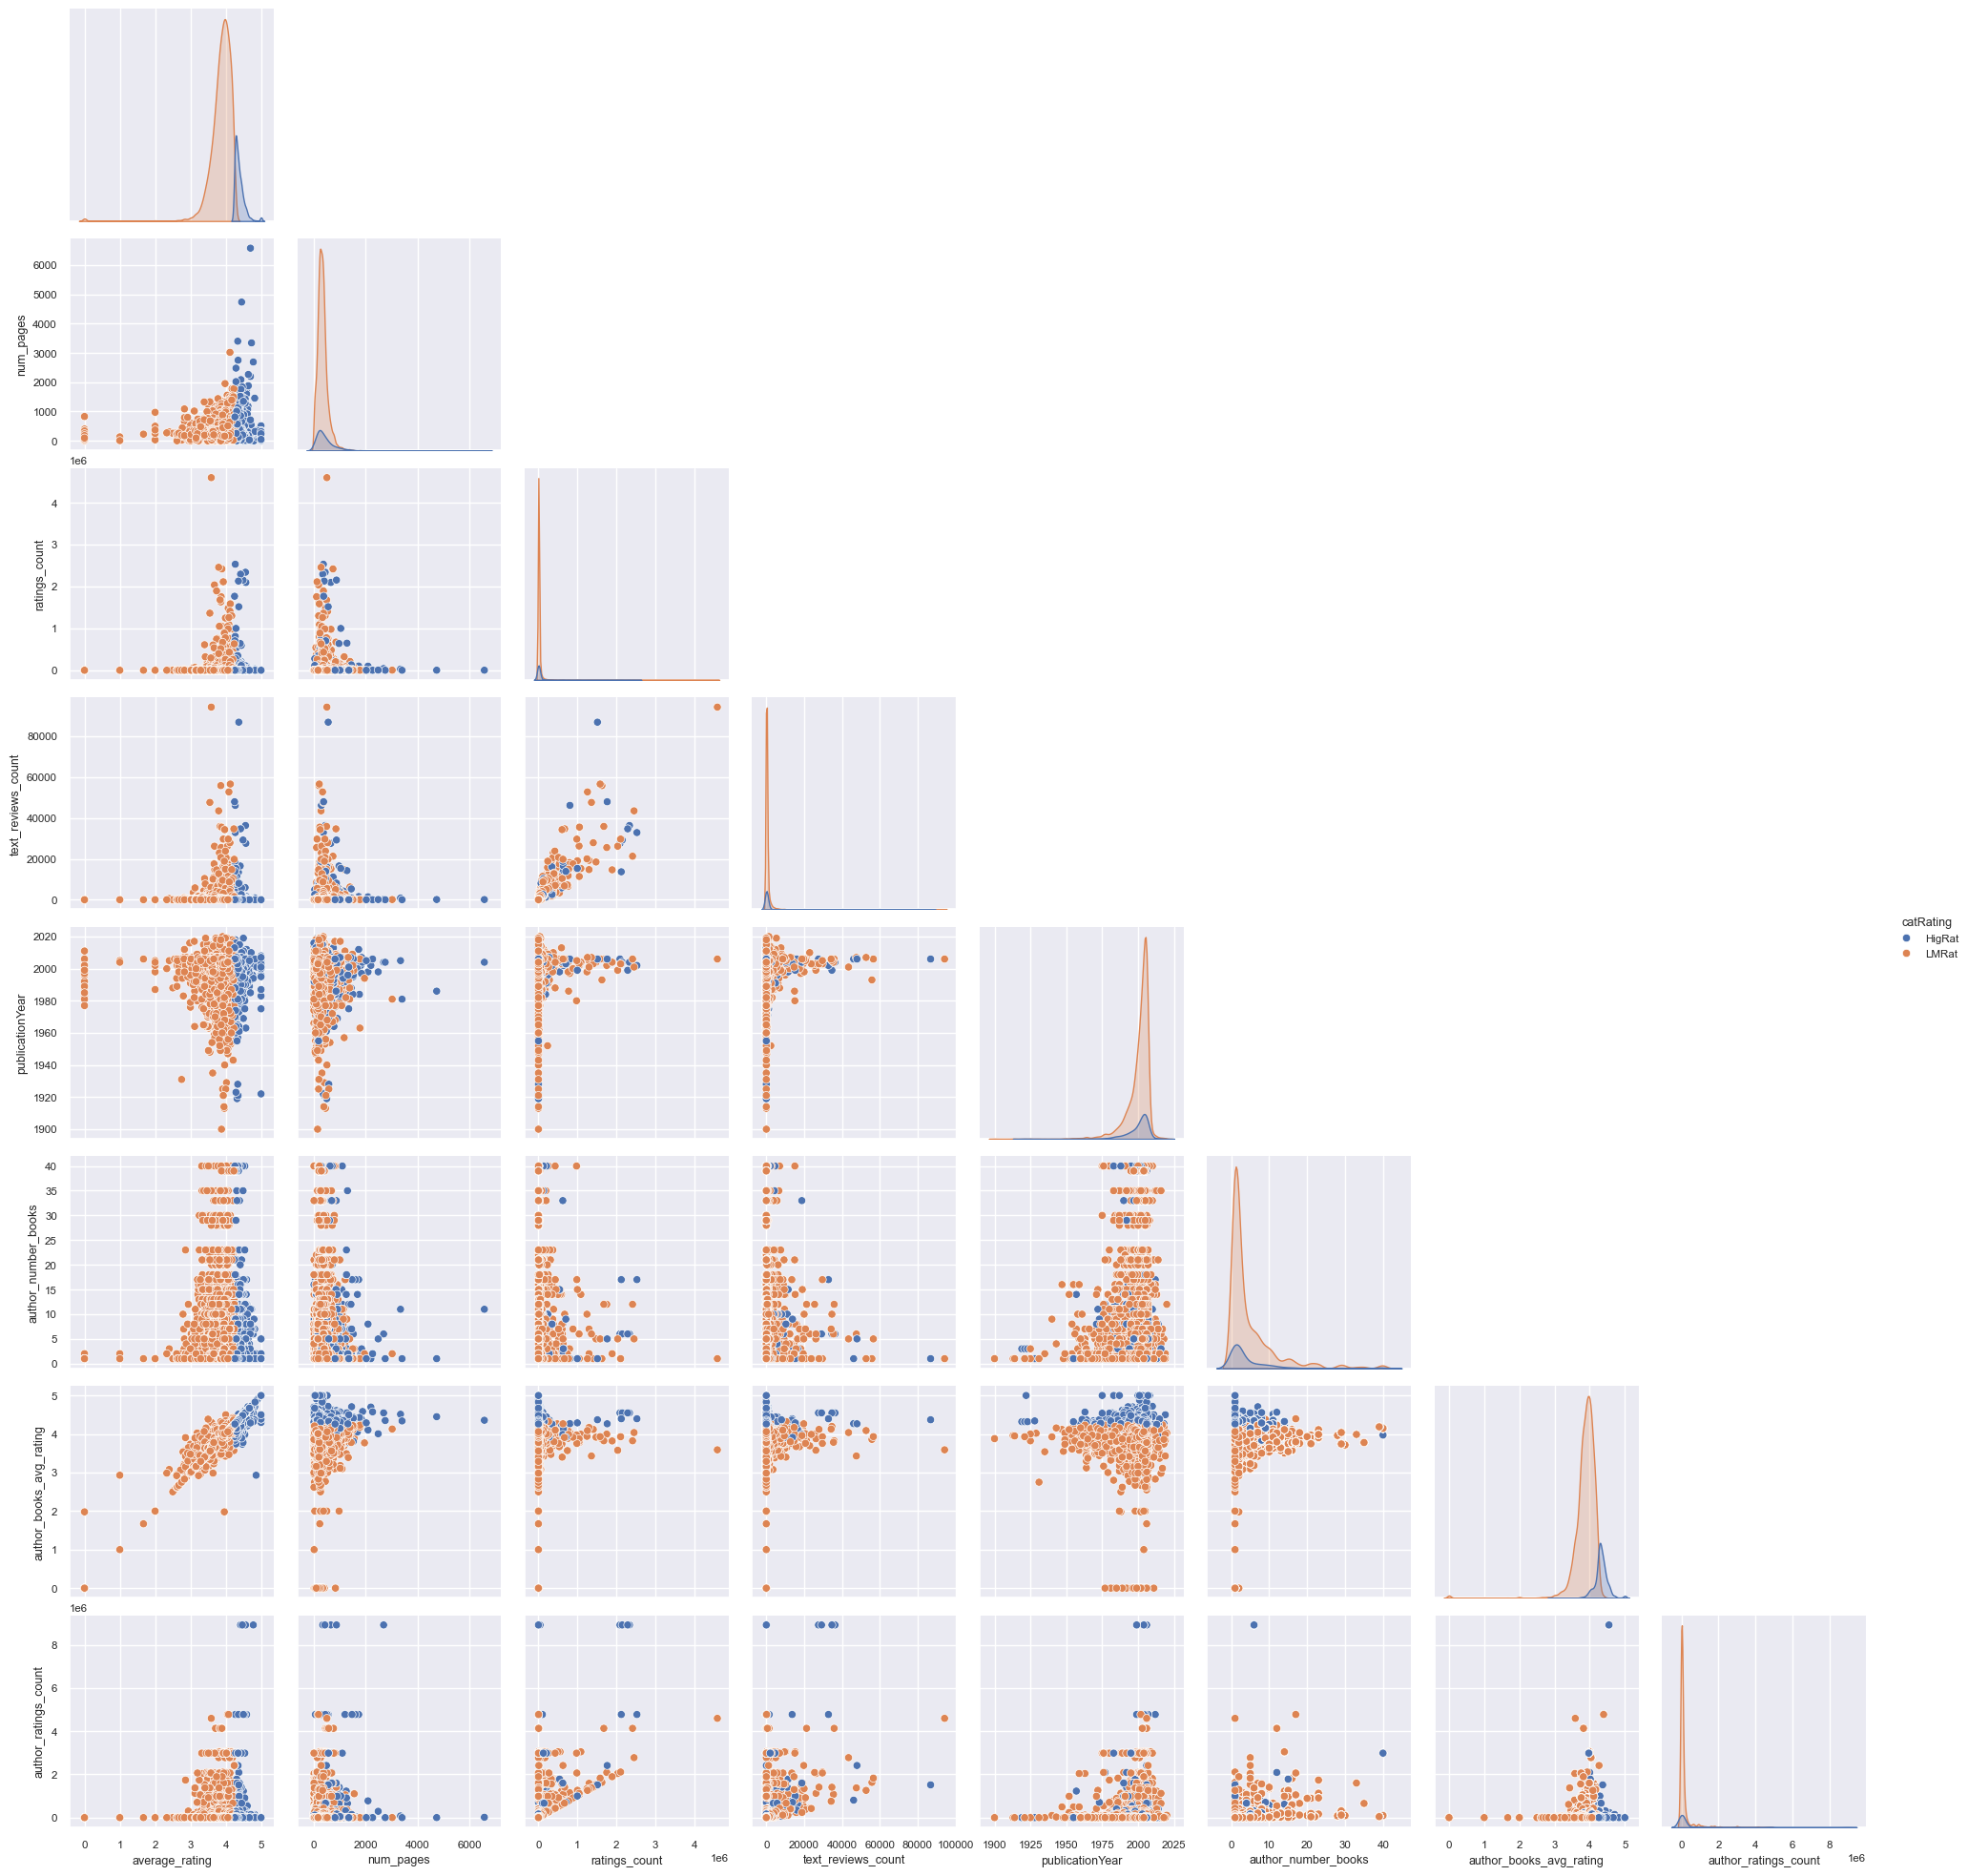

In [714]:
#Let's also look at again the new pair relations

col = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
        'publicationYear','author_number_books','author_books_avg_rating','author_ratings_count',"catRating"]

sns.pairplot(df[col],hue="catRating", corner=True) 

In [715]:
#Check the number of unique authors
len(df['authors'].unique())



6643

# Modeling

## Modeling - Preprocessing

In [716]:
dfmodel = df.copy()

print(dfmodel.head())

                                               title  \
0  Harry Potter and the Half-Blood Prince (Harry ...   
1  Harry Potter and the Order of the Phoenix (Har...   
2  Harry Potter and the Prisoner of Azkaban (Harr...   
3  Harry Potter Boxed Set  Books 1-5 (Harry Potte...   
4  Harry Potter and the Chamber of Secrets (Harry...   

                      authors  average_rating        isbn         isbn13  \
0  J.K. Rowling/Mary GrandPré            4.57  0439785960  9780439785969   
1  J.K. Rowling/Mary GrandPré            4.49  0439358078  9780439358071   
2  J.K. Rowling/Mary GrandPré            4.56  043965548X  9780439655484   
3  J.K. Rowling/Mary GrandPré            4.78  0439682584  9780439682589   
4  J.K. Rowling/Mary GrandPré            4.42  0439064864  9780439064866   

  language_code  num_pages  ratings_count  text_reviews_count  \
0           eng        652        2095690               27591   
1           eng        870        2153167               29221   
2          

In [717]:
print(dfmodel.dtypes)
dfmodel.head()

title                              object
authors                            object
average_rating                    float64
isbn                               object
isbn13                              int64
language_code                      object
num_pages                           int64
ratings_count                       int64
text_reviews_count                  int64
publication_date           datetime64[ns]
publisher                          object
publicationYear                     int32
language_code_grouped              object
catRating                          object
author_number_books                 int64
author_books_avg_rating           float64
author_ratings_count                int64
dtype: object


,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,publicationYear,language_code_grouped,catRating,author_number_books,author_books_avg_rating,author_ratings_count
0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,2006,eng,HigRat,6,4.548333,8923980
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,2004,eng,HigRat,6,4.548333,8923980
2,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,2004-05-01,Scholastic Inc.,2004,eng,HigRat,6,4.548333,8923980
3,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,2004-09-13,Scholastic,2004,eng,HigRat,6,4.548333,8923980
4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling/Mary GrandPré,4.42,0439064864,9780439064866,eng,341,2293963,34692,1999-06-02,Arthur A. Levine Books / Scholastic Inc.,1999,eng,HigRat,6,4.548333,8923980


##### Handle outliers

In [718]:
#%%outliers

#The process of identifying outliers has many names in data mining and machine 
# learning such as outlier mining, outlier modeling and novelty detection and 
# anomaly detection.In his book "Outlier Analysis", Aggarwal provides a useful taxonomy
#  of outlier detection methods.

#one possibility:Delimit the variables using 3 standard deviations

columns =['num_pages','ratings_count','text_reviews_count']

for c in columns:
    data_mean, data_std = np.mean(dfmodel[c]), np.std(dfmodel[c])
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off

    dfmodel[c]= [upper if x > upper else x for x in df[c]]

dfmodel.describe()

,average_rating,isbn13,num_pages,ratings_count,text_reviews_count,publication_date,publicationYear,author_number_books,author_books_avg_rating,author_ratings_count
count,11127.000000,1.112700e+04,11127.000000,11127.000000,11127.000000,11127,11127.000000,11127.000000,11127.000000,1.112700e+04
mean,3.933631,9.759888e+12,331.004626,12876.755461,426.618096,2000-08-27 22:58:00.614720896,2000.167520,4.778377,3.933631,1.275979e+05
min,0.000000,8.987060e+09,0.000000,0.000000,0.000000,1900-01-01 00:00:00,1900.000000,1.000000,0.000000,0.000000e+00
25%,3.770000,9.780345e+12,192.000000,104.000000,9.000000,1998-07-16 12:00:00,1998.000000,1.000000,3.790000,2.560000e+02
50%,3.960000,9.780586e+12,299.000000,745.000000,46.000000,2003-03-01 00:00:00,2003.000000,2.000000,3.950000,3.679000e+03
75%,4.135000,9.780873e+12,416.000000,4993.500000,237.500000,2005-09-30 00:00:00,2005.000000,6.000000,4.110000,4.386800e+04
max,5.000000,9.790008e+12,1059.726331,355359.570059,8270.037027,2020-03-31 00:00:00,2020.000000,40.000000,5.000000,8.923980e+06
std,0.352445,4.428964e+11,206.766439,44290.974482,1199.900322,NaN,8.248836,6.794984,0.329410,4.649757e+05


array([[<Axes: title={'center': 'average_rating'}>,
        <Axes: title={'center': 'isbn13'}>,
        <Axes: title={'center': 'num_pages'}>],
       [<Axes: title={'center': 'ratings_count'}>,
        <Axes: title={'center': 'text_reviews_count'}>,
        <Axes: title={'center': 'publicationYear'}>],
       [<Axes: title={'center': 'author_number_books'}>,
        <Axes: title={'center': 'author_books_avg_rating'}>,
        <Axes: title={'center': 'author_ratings_count'}>]], dtype=object)

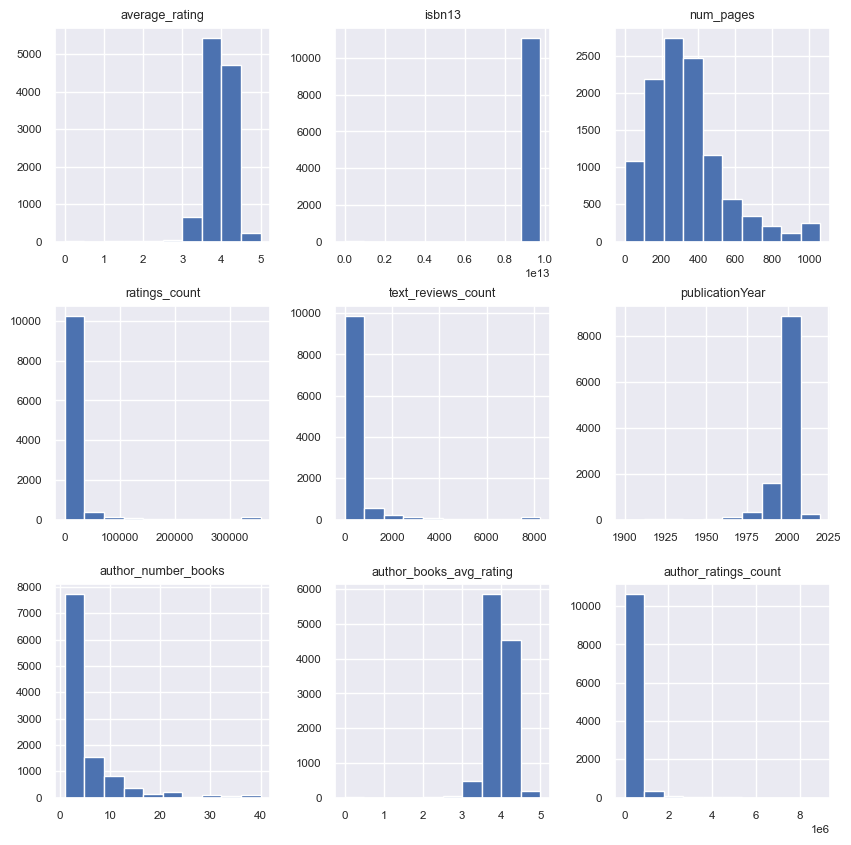

In [719]:
dfmodel.select_dtypes(["float64","int64","int32"]).hist(figsize=(10, 10))

In [720]:
dfmodel.head(3)

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,publicationYear,language_code_grouped,catRating,author_number_books,author_books_avg_rating,author_ratings_count
0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652.0,355359.570059,8270.037027,2006-09-16,Scholastic Inc.,2006,eng,HigRat,6,4.548333,8923980
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870.0,355359.570059,8270.037027,2004-09-01,Scholastic Inc.,2004,eng,HigRat,6,4.548333,8923980
2,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435.0,355359.570059,8270.037027,2004-05-01,Scholastic Inc.,2004,eng,HigRat,6,4.548333,8923980


##### Rename categories

In [721]:
# Apply the function, to rename categories

dicCat = {"HigRat": "1",
        "LMRat": "0"}

dfmodel["catRating"] = dfmodel["catRating"].apply(lambda x: dicCat[x])


##### Select features and split data

In [722]:
#ratings_count kept but not text_reviews_count because of the high correlation mentioned above
#X = dfmodel[['num_pages','ratings_count','publicationYear','language_code_grouped']]
#X = dfmodel[['author_number_books','num_pages','ratings_count','publicationYear','language_code_grouped']]
#X = dfmodel[['author_ratings_count','num_pages','ratings_count','publicationYear','language_code_grouped']]
X = dfmodel[['author_number_books','author_ratings_count','num_pages','ratings_count','publicationYear','language_code_grouped']]
y = dfmodel.loc[:, "catRating"]

#split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1, stratify=y
)

##### Encode target column

In [723]:
#Encode target column
label_encode = LabelEncoder()
label_encode.fit(y_train)
y_train = label_encode.transform(y_train)
y_test = label_encode.transform(y_test)

In [724]:
print(X_train.describe())
print(X_test.describe())

       author_number_books  author_ratings_count    num_pages  ratings_count  \
count          8901.000000          8.901000e+03  8901.000000    8901.000000   
mean              4.797663          1.254796e+05   330.783462   12769.428946   
std               6.829584          4.521500e+05   208.028120   44080.545068   
min               1.000000          0.000000e+00     0.000000       0.000000   
25%               1.000000          2.540000e+02   192.000000     102.000000   
50%               2.000000          3.614000e+03   297.000000     725.000000   
75%               6.000000          4.455300e+04   416.000000    4850.000000   
max              40.000000          8.923980e+06  1059.726331  355359.570059   

       publicationYear  
count      8901.000000  
mean       2000.138861  
std           8.434229  
min        1900.000000  
25%        1998.000000  
50%        2003.000000  
75%        2005.000000  
max        2020.000000  
       author_number_books  author_ratings_count    nu

In [725]:
cont_ix = X_train.select_dtypes(exclude=["object"]).columns
cat_ix = X_train.select_dtypes(include=["object"]).columns

cont_pipeline = make_pipeline(
    RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
)

cat_pipeline = make_pipeline(OneHotEncoder(drop="first"))

preprocessor = ColumnTransformer(
    transformers=[
        ("cont", cont_pipeline, cont_ix),
        ("cat", cat_pipeline, cat_ix),
    ]
)

dt = Pipeline(steps=[("preprocessor", preprocessor)])
dt.fit(X_train)

xtrain_dt = dt.transform(X_train)


In [726]:
#Check data shape
xtrain_dt.shape

(8901, 10)

In [727]:
var_list = list(dt.get_feature_names_out())
X_train = pd.DataFrame(xtrain_dt, columns=var_list)

xtest_dt = dt.transform(X_test)
X_test = pd.DataFrame(xtest_dt, columns=var_list)

In [728]:
print(X_train.head())
print(X_test.head())

   cont__author_number_books  cont__author_ratings_count  cont__num_pages  \
0                        0.4                    0.453148         0.031250   
1                        1.2                   35.069505         0.276786   
2                       -0.2                   -0.072259        -0.361607   
3                       -0.2                   -0.080589         0.299107   
4                        0.0                    0.690128         0.482143   

   cont__ratings_count  cont__publicationYear  cat__language_code_grouped_fre  \
0            -0.107835               0.285714                             0.0   
1            23.163648               0.571429                             0.0   
2            -0.065712               0.285714                             0.0   
3            -0.143429               0.428571                             0.0   
4             2.688711               0.000000                             0.0   

   cat__language_code_grouped_ger  cat__language_c

## Modeling - Regression

In [729]:
yCont = dfmodel.loc[:, "average_rating"]
yCont_train, yCont_test = train_test_split(
    yCont, train_size=0.8, random_state=1
)

In [730]:
print(yCont.describe())
print(yCont_train.describe())
print(yCont_test.describe())

count    11127.000000
mean         3.933631
std          0.352445
min          0.000000
25%          3.770000
50%          3.960000
75%          4.135000
max          5.000000
Name: average_rating, dtype: float64
count    8901.000000
mean        3.934547
std         0.350124
min         0.000000
25%         3.770000
50%         3.960000
75%         4.130000
max         5.000000
Name: average_rating, dtype: float64
count    2226.000000
mean        3.929969
std         0.361635
min         0.000000
25%         3.770000
50%         3.960000
75%         4.140000
max         5.000000
Name: average_rating, dtype: float64


In [731]:
#As expected above, linear Modeling do not perform well,
#even if we add some non linearity in the modeling (e.g. polynomial linear regression, etc)

In [732]:
#Modeling - Linear regression model
linReg = LinearRegression().fit(X_train, yCont_train)
print("Linear Training set score: {:.3f}".format(linReg.score(X_train,yCont_train)))
print("Linear Test set score: {:.3f}".format(linReg.score(X_test,yCont_test)))

Linear Training set score: 0.001
Linear Test set score: -0.001


In [733]:
#Modeling - KNN regression model
KNN = KNeighborsRegressor (n_neighbors=7)
KNN.fit(X_train, yCont_train)
print("Linear Training set score: {:.3f}".format(KNN.score(X_train,yCont_train)))
print("Linear Test set score: {:.3f}".format(KNN.score(X_test,yCont_test)))

Linear Training set score: 0.147
Linear Test set score: -0.141


In [734]:
#Modeling - Ridge Linear Regression
ridge= Ridge().fit(X_train, yCont_train)
print("Ridge with alpha=1")
print("Training set score: {:.2f}".format(ridge.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, yCont_test)))

print("\nRidge with alpha=10")
ridge10= Ridge(alpha=10).fit(X_train, yCont_train)
print("Training set score: {:.2f}".format(ridge10.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(ridge10.score(X_test, yCont_test)))

ridge01= Ridge(alpha=0.1).fit(X_train, yCont_train)
print("\nRidge with alpha=0.1")
print("Training set score: {:.2f}".format(ridge01.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(ridge01.score(X_test, yCont_test)))

Ridge with alpha=1
Training set score: 0.00
Test set score: -0.00

Ridge with alpha=10
Training set score: 0.00
Test set score: -0.00

Ridge with alpha=0.1
Training set score: 0.00
Test set score: -0.00


In [735]:
#Modeling - Lasso Linear Regression (Least Absolute Shrinkage And Selection Operator)
lasso = Lasso().fit(X_train, yCont_train)
print("Lasso with alpha=1")
print("Training set score: {:.2f}".format(lasso.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, yCont_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ !=0)))

#Lasso with less regularisation
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, yCont_train)
print("\nLasso with alpha=0.01")
print("Training set score: {:.2f}".format(lasso001.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(lasso001.score(X_test, yCont_test)))
print("Number of features used: {}".format(np.sum(lasso001.coef_ !=0)))

#Lasso with even less regularisation
lasso00001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train, yCont_train)
print("\nLasso with alpha=0.0001")
print("Training set score: {:.2f}".format(lasso00001.score(X_train, yCont_train)))
print("Test set score: {:.2f}".format(lasso00001.score(X_test, yCont_test)))
print("Number of features used: {}".format(np.sum(lasso00001.coef_ !=0)))

Lasso with alpha=1
Training set score: 0.00
Test set score: -0.00
Number of features used: 0

Lasso with alpha=0.01
Training set score: 0.00
Test set score: 0.00
Number of features used: 2

Lasso with alpha=0.0001
Training set score: 0.00
Test set score: -0.00
Number of features used: 7


In [736]:
#Modeling - Polynomial Linear Regression
# the default "include_bias=True" adds a feature that's constantly 1
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)
X_poly_train = poly.transform(X_train)
X_poly_test = poly.transform(X_test)

print("X.shape: {}".format(X.shape))
print("X_train.shape: {}".format(X_train.shape))
print("X_poly_train.shape: {}".format(X_poly_train.shape))
print("Entries of X:\n{}".format(X[:5]))
print("Entries of X_train:\n{}".format(X_train[:5]))
print("Entries of X_poly_train:\n{}".format(X_poly_train[:5]))
print("Polynomial feature names:\n{}".format(poly.get_feature_names_out()))

X.shape: (11127, 6)
X_train.shape: (8901, 10)
X_poly_train.shape: (8901, 65)
Entries of X:
   author_number_books  author_ratings_count    num_pages  ratings_count  \
0                    6               8923980   652.000000  355359.570059   
1                    6               8923980   870.000000  355359.570059   
2                    6               8923980   435.000000  355359.570059   
3                    6               8923980  1059.726331   41428.000000   
4                    6               8923980   341.000000  355359.570059   

   publicationYear language_code_grouped  
0             2006                   eng  
1             2004                   eng  
2             2004                   eng  
3             2004                   eng  
4             1999                   eng  
Entries of X_train:
   cont__author_number_books  cont__author_ratings_count  cont__num_pages  \
0                        0.4                    0.453148         0.031250   
1                   

In [737]:
poly_linreg = LinearRegression().fit(X_poly_train, yCont_train)
print("Poly Training set score: {:.3f}".format(poly_linreg.score(X_poly_train,yCont_train)))
print("Poly Test set score: {:.3f}".format(poly_linreg.score(X_poly_test,yCont_test)))

Poly Training set score: 0.008
Poly Test set score: -0.006


In [738]:
from sklearn.svm import LinearSVR

linSVR = LinearSVR(max_iter=2000)
linSVR.fit(X_train, yCont_train)
print("SGD linear regressor Training set score: {:.3f}".format(linSVR.score(X_train,yCont_train)))
print("SGD linear regressor Test set score: {:.3f}".format(linSVR.score(X_test,yCont_test)))

c:\Users\datas\DSTI_2324\PythonMLProject\20231207_backup_20240106\.venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



SGD linear regressor Training set score: -0.025
SGD linear regressor Test set score: -0.027


c:\Users\datas\DSTI_2324\PythonMLProject\20231207_backup_20240106\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [739]:
RFReg = RandomForestRegressor(max_depth=2, random_state=0)
RFReg.fit(X_train, yCont_train)
print("Random Forest regressor Training set score: {:.3f}".format(RFReg.score(X_train,yCont_train)))
print("Random Forest regressor Test set score: {:.3f}".format(RFReg.score(X_test,yCont_test)))

Random Forest regressor Training set score: 0.006
Random Forest regressor Test set score: -0.001


[ 0.00035676 -0.00070723 -0.0029427  -0.00194981 -0.00335052]
LinR: -0.001719 (0.001382)
[-0.55190631 -0.47713764 -0.38681323 -0.49370731 -0.5401741 ]
KNN: -0.489948 (0.058611)
[ 0.00034224 -0.00070603 -0.00288407 -0.0019262  -0.00333098]
ridge: -0.001701 (0.001362)
[ 0.00024709 -0.00068877 -0.0025368  -0.00177021 -0.0031878 ]
ridge10: -0.001587 (0.001238)
[ 0.00035526 -0.00070712 -0.00293657 -0.00194737 -0.00334852]
ridge01: -0.001717 (0.001380)
[-2.06993374e-04 -1.17228086e-04 -9.00959697e-04 -7.99417689e-05
 -1.39201981e-03]
lasso: -0.000539 (0.000521)
[-2.13515178e-04 -2.33123776e-05 -1.06806815e-03  8.40574263e-05
 -1.62729441e-03]
lasso001: -0.000570 (0.000666)
[ 0.00012055 -0.00053075 -0.00256386 -0.00154705 -0.00278442]
lasso00001: -0.001461 (0.001126)
[ 0.00443667 -0.03610609 -0.00536225 -0.00292968 -0.10639037]
polyLinreg: -0.029270 (0.040978)
[-0.07623442 -0.02280327 -0.01416264 -0.03179957 -0.02165375]
linSVR: -0.033331 (0.022171)
[ 0.00050578  0.00045757 -0.00081659 -0.001

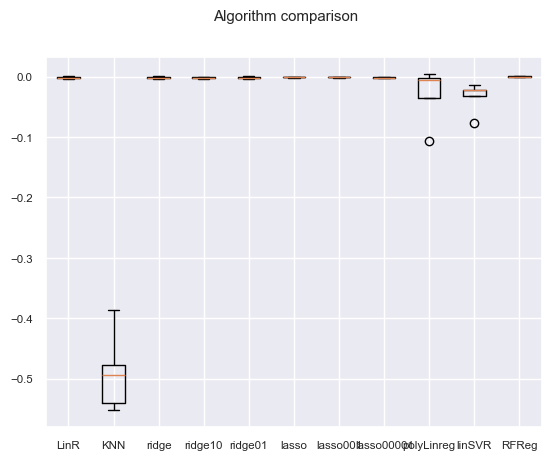

In [740]:
#Model comparison
models = []
models.append(("LinR", LinearRegression()))
models.append(("KNN", KNeighborsRegressor (n_neighbors=2)))
models.append(("ridge", Ridge(alpha=1)))
models.append(("ridge10", Ridge(alpha=10)))
models.append(("ridge01", Ridge(alpha=0.1)))
models.append(("lasso", Lasso(alpha=1)))
models.append(("lasso001", Lasso(alpha=0.01, max_iter=100000)))
models.append(("lasso00001", Lasso(alpha=0.0001, max_iter=100000)))
models.append(("polyLinreg", LinearRegression()))
models.append(("linSVR", LinearSVR(max_iter=2000)))
models.append(("RFReg", RandomForestRegressor(max_depth=2, random_state=0)))

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    if name=='polyLinreg':
        cv_results = cross_val_score(
        model, X_poly_train, yCont_train, cv=kfold, n_jobs=-1
        )
    else:
        cv_results = cross_val_score(
        model, X_train, yCont_train, cv=kfold, n_jobs=-1
        )
    print(cv_results)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot to compare
fig = plt.figure()
fig.suptitle("Algorithm comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Classification models

LR: 0.584823 (0.032704)
LDA: 0.579036 (0.032403)
KNN: 0.642029 (0.022526)
RF: 0.700033 (0.027394)
CART: 0.581439 (0.018618)
NB: 0.607147 (0.032798)
SVM: 0.593452 (0.032527)


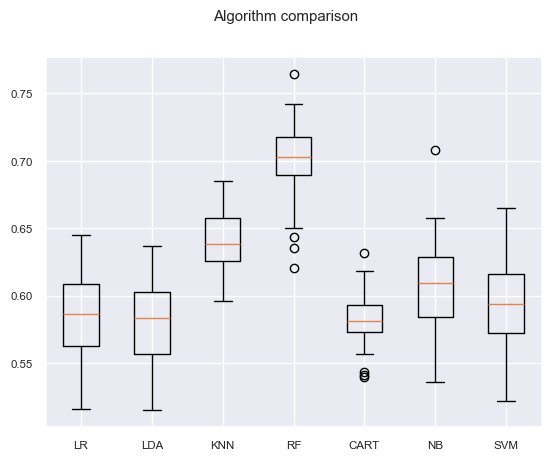

In [741]:
#base line
models = []
models.append(("LR", LogisticRegression(solver="lbfgs", class_weight="balanced")))
models.append(("LDA", LinearDiscriminantAnalysis()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("RF",RandomForestClassifier(n_estimators=100, random_state=1, class_weight="balanced"),))
models.append(("CART", DecisionTreeClassifier(class_weight="balanced")))
models.append(("NB", GaussianNB()))
models.append(("SVM", SVC(gamma="scale", class_weight="balanced")))
#models.append(("XGB", XGBClassifier()))

results = []
names = []
scoring = "roc_auc"

for name, model in models:
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
    cv_results = cross_val_score(
        model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1
    )
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot to compare
fig = plt.figure()
fig.suptitle("Algorithm comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [742]:
#We get better results by using classification models.
#Repeated Stratified cross validation with different randomization in each repetition ends up with Random Forest as the best model.

In [743]:
#Let's focus on Random Forest then and use a Grid search for hyperparameters in addition to the cross validation

#WARNING : it can take up to 50 mn to run with stop=2000
#WARNING : it can take up to 10 mn to run with stop=101
n_estimators = [int(x) for x in np.linspace(start=100, stop=101, num=20)]
max_features = ["log2", "sqrt"]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# grid
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}
random_grid

#hyperparameters random search
rf = RandomForestClassifier(class_weight="balanced")

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=50,
    n_jobs=-1,
)

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 100, 100, 100,
                                                         100, 100, 100, 100,
                                                         100, 100, 100, 100,
                                                         100, 100, 100, 100,
                                                         100, 100, 100, 101]},
                   random_state=50, verbose=2)

In [744]:
#Results of hyperparameters random search 
print("Best parameters of Random Forest after grid search and cross validations are:\n {}\n".format(rf_random.best_params_))
#results with stop = 2000 without author and publisher
#Fitting 5 folds for each of 100 candidates, totalling 500 fits
#{'n_estimators': 1500,
# 'min_samples_split': 2,
# 'min_samples_leaf': 1,
# 'max_features': 'log2',
# 'max_depth': 80,
# 'bootstrap': True}

print("Corresponding best cross validations score is:\n{}\n".format(rf_random.best_score_))

print("Corresponding Test sest score is:\n{}".format(rf_random.score(X_test, y_test)))

Best parameters of Random Forest after grid search and cross validations are:
 {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}

Corresponding best cross validations score is:
0.873947536102051

Corresponding Test sest score is:
0.8724168912848158


In [745]:
#The test score is the most relevant to check to evaluate the model generalization.

In [746]:
# prediction
##???
##print(rf_random.best_params_.
      ##predict_proba(X_test))


RF = RandomForestClassifier(
    n_estimators=rf_random.best_params_["n_estimators"],
    min_samples_split=rf_random.best_params_["min_samples_split"],
    min_samples_leaf=rf_random.best_params_["min_samples_leaf"],
    max_features=rf_random.best_params_["max_features"],
    max_depth=rf_random.best_params_["max_depth"],
    bootstrap=rf_random.best_params_["bootstrap"],
    random_state=50,
    ##??? random_state=1,
    class_weight="balanced",
)
RF.fit(X_train, y_train)
yhatRF = RF.predict_proba(X_test)
print(yhatRF)

[[0.89 0.11]
 [0.92 0.08]
 [0.98 0.02]
 ...
 [0.76 0.24]
 [0.86 0.14]
 [0.44 0.56]]


Feature: 0, Score: 0.08152
Feature: 1, Score: 0.22933
Feature: 2, Score: 0.28177
Feature: 3, Score: 0.22904
Feature: 4, Score: 0.15198
Feature: 5, Score: 0.00432
Feature: 6, Score: 0.00271
Feature: 7, Score: 0.00739
Feature: 8, Score: 0.00665
Feature: 9, Score: 0.00529


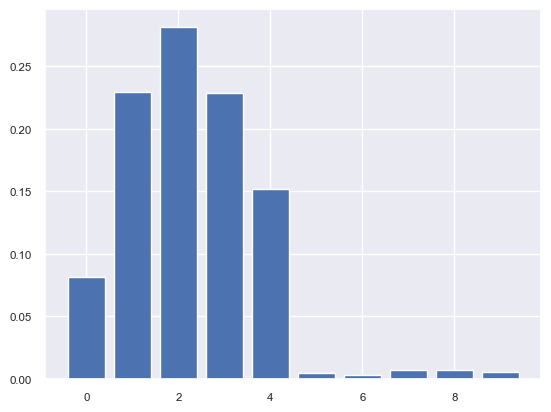

In [747]:
# variable importances
importRF = RF.feature_importances_  # also known as the Gini importance.
for i, v in enumerate(importRF):
    print("Feature: %0d, Score: %.5f" % (i, v))

plt.bar([x for x in range(len(importRF))], importRF)
plt.show()


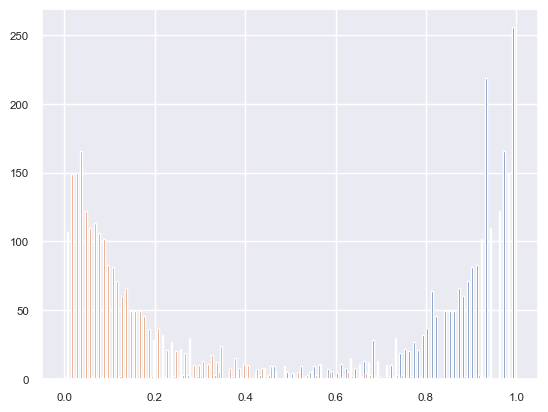

In [748]:

# Histogram of probabilities 
plt.hist(yhatRF, bins=100)
plt.show()


## Modelisation - Model evaluation

In [749]:
# Positive class probabilities
yhatRFPos = yhatRF[:, 1]

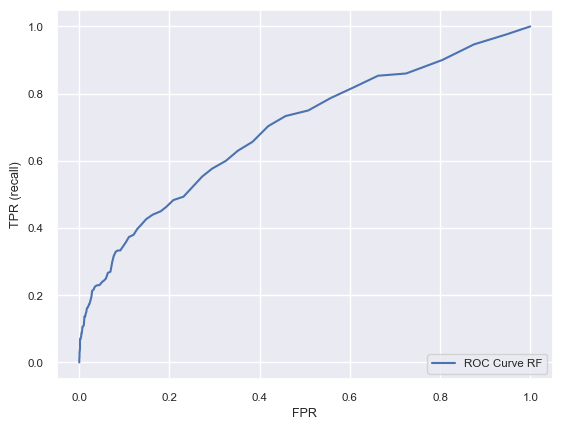

In [750]:

#roc_curve
##plot_pr_curve(y_test, yhatRF, "RF")
fpr_rf, tpr_rf, _ = roc_curve (y_test, yhatRFPos)
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.legend(loc=4)
#plt.show()


# se prueba con el Threshold del scoresfbeta pero se modifica
#yhatRF_class = CurvasUmbral.to_labels(yhatRF, 0.15)

#print(classification_report(y_test, yhatRF_class))
#print("ROC AUC score:", roc_auc_score(y_test, yhatRF_class))
#print(confusion_matrix(y_test, yhatRF_class))

In [751]:
#Confusion matrix
y_test_predictRF = RF.predict(X_test)
print("confusion_matrix is:\n{}".format(confusion_matrix(y_test, y_test_predictRF)))

confusion_matrix is:
[[1894   32]
 [ 252   48]]


In [752]:
print(classification_report(y_test, y_test_predictRF,
      target_names=["LMRat","HigRat"]))

              precision    recall  f1-score   support

       LMRat       0.88      0.98      0.93      1926
      HigRat       0.60      0.16      0.25       300

    accuracy                           0.87      2226
   macro avg       0.74      0.57      0.59      2226
weighted avg       0.84      0.87      0.84      2226



In [753]:
print("ROC AUC score:", roc_auc_score(y_test, yhatRFPos))

ROC AUC score: 0.693157667012807
